In [2]:
from transformers import (AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments,
                          DataCollatorWithPadding, Trainer, pipeline)
from sklearn.model_selection import train_test_split
from transformers.pipelines.pt_utils import KeyDataset
from datasets import load_dataset, Dataset
import torch, wandb, evaluate
from tqdm.auto import tqdm
import numpy as np

# **FINETUNING BERT ON PHISHING DETECTION**

BERT is a model that pre-trains deep bidirectional representations from unlabeled text using masked language modeling and next sentence prediction objectives. It can be fine-tuned with just one additional output layer to create state-of-the-art models for various natural language processing tasks, such as text classification, token classification, question answering, and more. BERT is good for classification tasks as phishing classification because it can capture the context and semantics of the text from both left and right directions, and learn to predict the correct label based on the pre-trained knowledge. BERT also has a special [CLS] token that is used for classification tasks, which is trained to represent the whole input sequence and can be fed to a classifier layer. BERT has achieved impressive results on several text classification benchmarks, such as GLUE, SST-2, and CoLA.

This project will show how to:

- Finetune BERT on a custom phishing dataset to determine whether a text is phishing or benign.
- Use the finetuned model for inference.

## Load phishing dataset

We will train BERT on a [dataset](https://huggingface.co/datasets/ealvaradob/phishing-dataset) that combines a variety of data types, including: URLs, SMS, emails and websites. However, there are two datasets with this description that can be used:

- Full combined dataset
- Reduced combined dataset

The full combined dataset contains 97% URLs and 3% SMS, emails and websites for a total of more than 800,000 samples. A previous experiment on this dataset reveals negative results in phishing classification with BERT, as shown in the following graph of the loss function during training:

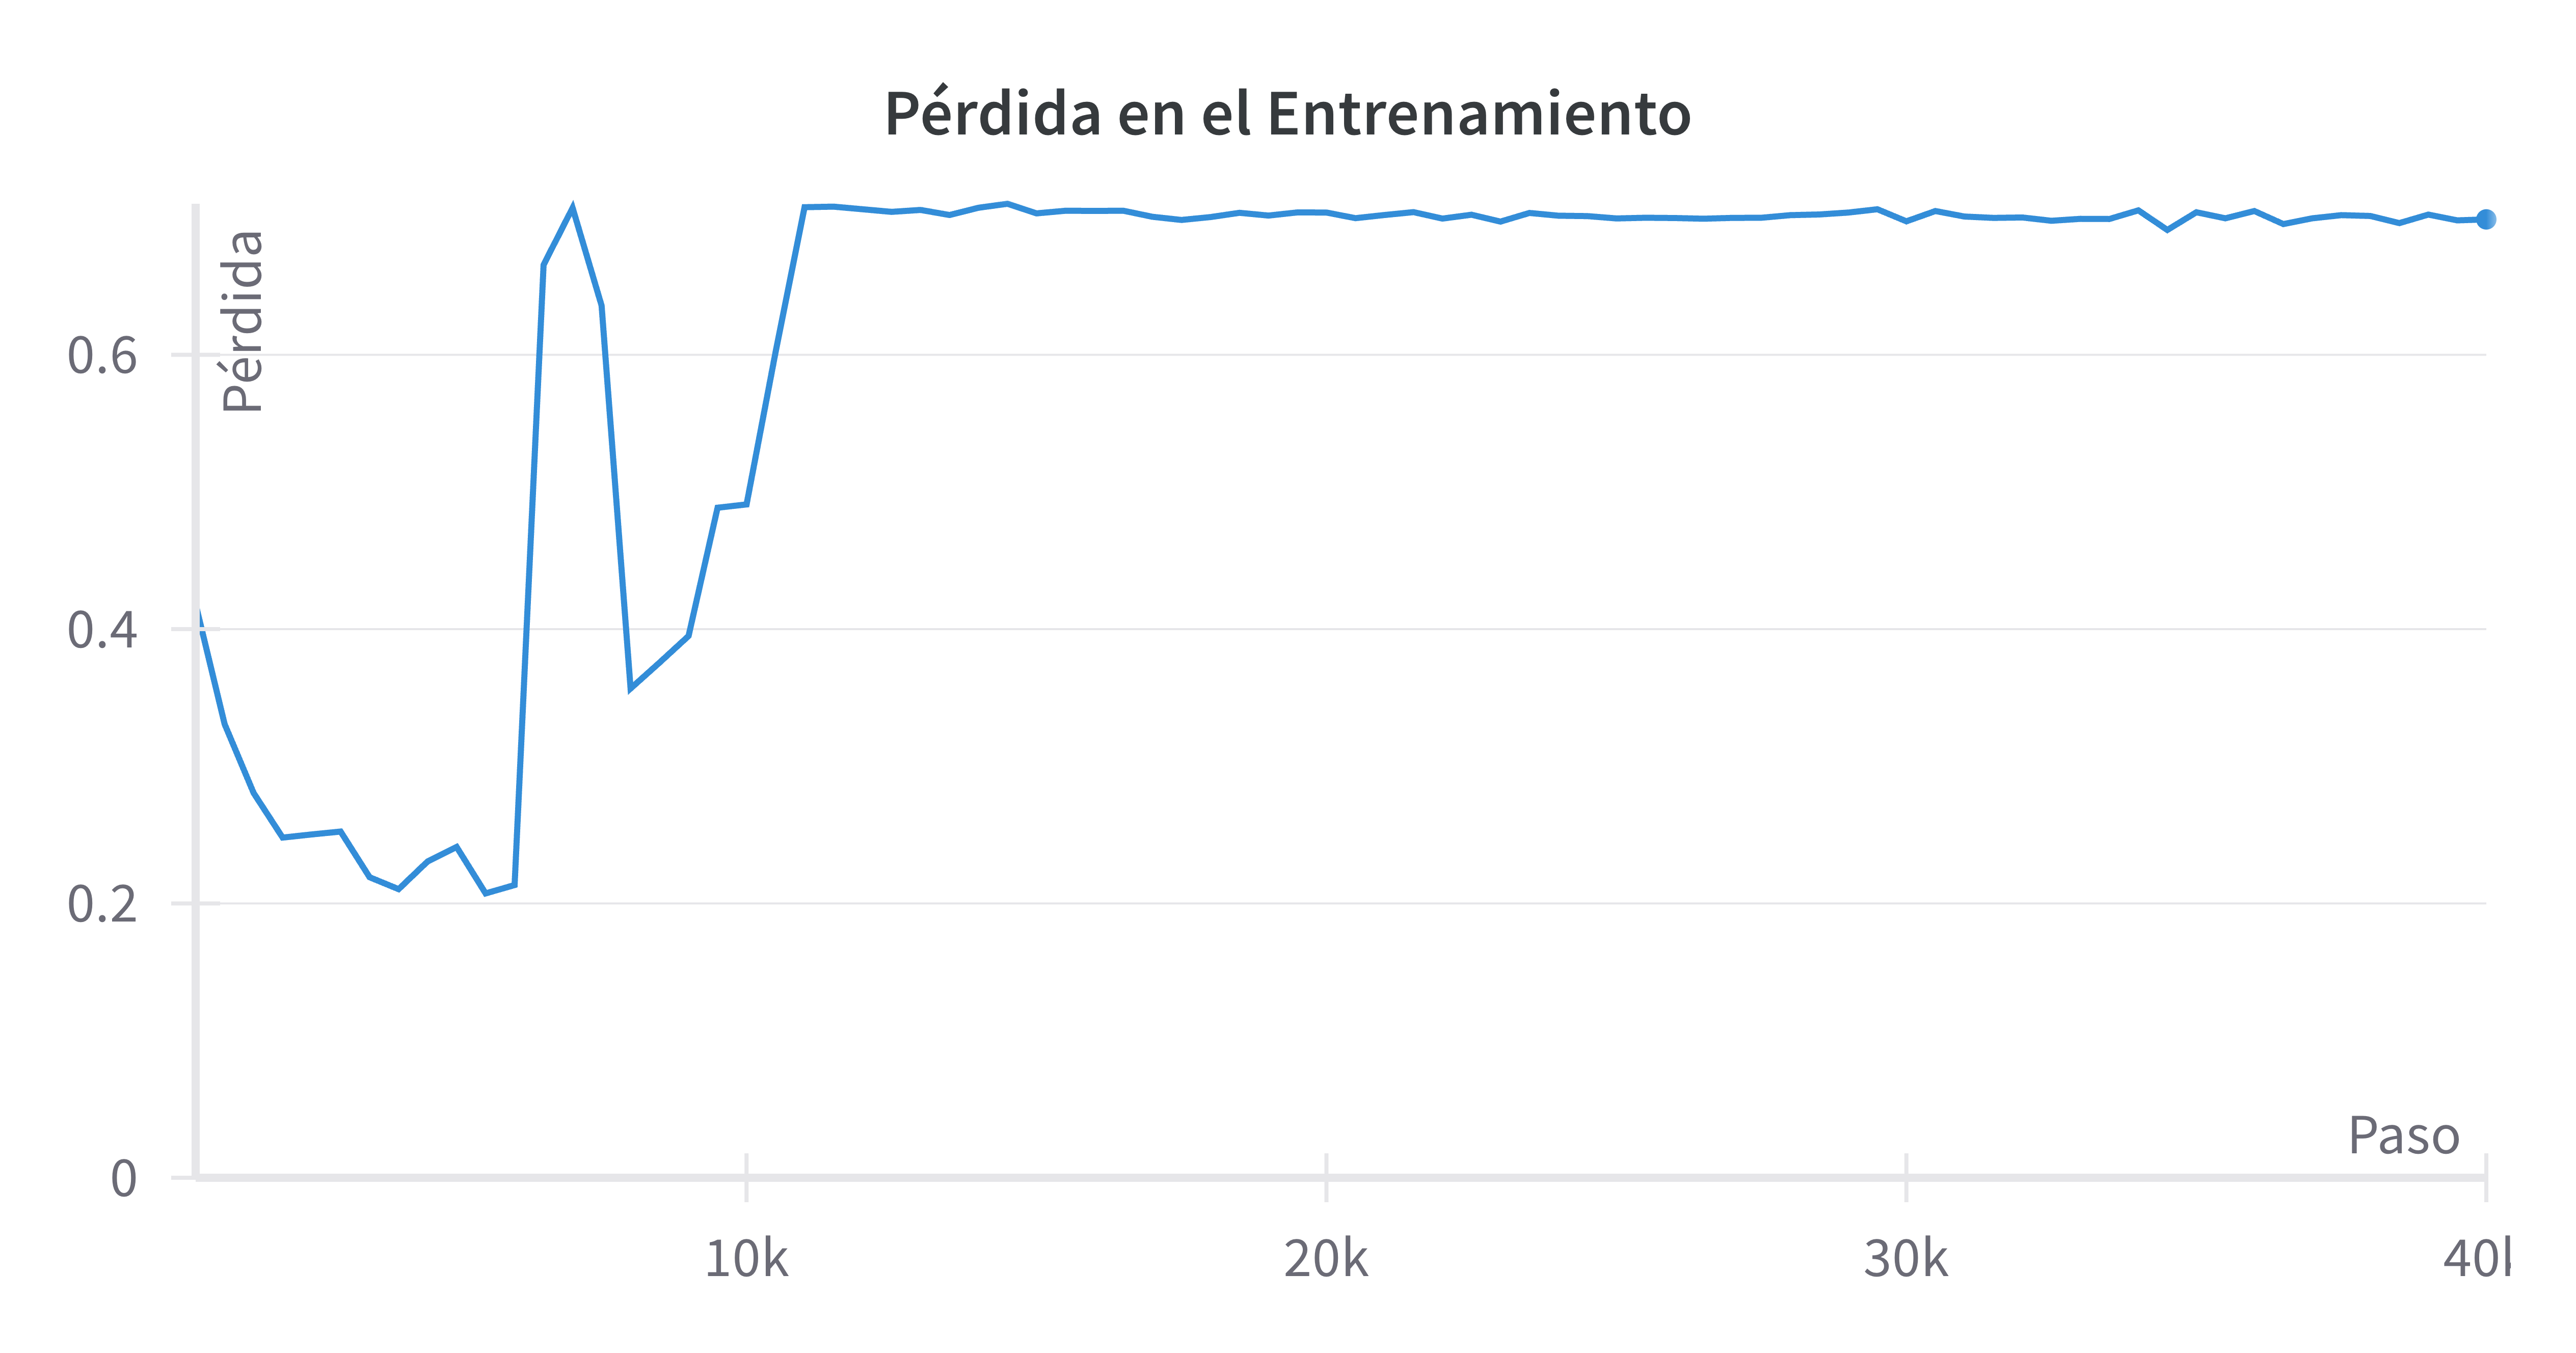

The loss function, also called the error function, is a crucial component in machine learning that provides a clear metric for evaluating the performance of a model by quantifying the difference between predictions and actual results. Although the algorithms of a machine learning model seek to minimize loss, in this case, the value of loss increased rather than decreased, and then remained constant. This implied that the model was not learning, and therefore, its predictions were poor. Therefore, we will use the **reduced dataset**, where the number of URLs were reduced by 95% in order to be representative for each type of data.

In [2]:
dataset = load_dataset("ealvaradob/phishing-dataset", "combined_reduced", trust_remote_code=True)

Let's see a sample of the dataset:

In [3]:
dataset['train'][1]

{'text': 'http://online0mgeving.ga/triodos/', 'label': 1}

There are two fields:

- `text`: Text that can contain URLs, HTML codes, mails, and SMS messages.
- `label`: 0 for benign, 1 for phishing

## Tokenize Dataset

The next step is to load a BERT tokenizer to preprocess the text field. BERT expects input data in a specific format, and the tokenizer is responsible for converting the text into that format. The tokenizer splits the text into tokens, which are the basic units of language that the model can understand. The tokenizer also adds special tokens, such as [CLS] and [SEP], to mark the beginning and the end of the text or the separation between two sentences. The tokenizer also converts the tokens into numerical indices that correspond to the vocabulary of the model. These indices are then fed to the model as inputs. By using the same tokenizer that was used to pre-train the model, you can ensure that the model can process the text correctly and produce meaningful outputs.

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased")

We will create a preprocessing function to tokenize `text` and truncate sequences to be no longer than BERT's maximum input length:

In [5]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

We will create a batch of examples using [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorWithPadding). It's more efficient to *dynamically pad* the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Evaluation metrics

Including a metric during training is often helpful for evaluating your model's performance. For phishing detection, the most important metrics are:

- **True-Positive Rate (TPR) or Recall** - This is the ratio of the number of phishing emails or websites that the model correctly identifies as phishing and the total number of phishing emails or websites. It measures how well the model can detect phishing attacks and avoid false negatives. A high TPR means that the model can catch most of the phishing attempts and protect the users from falling victim to them.

- **False-Positive Rate (FPR)**: This is the ratio of the number of legitimate emails or websites that the model incorrectly identifies as phishing and the total number of legitimate emails or websites. It measures how often the model makes mistakes and flags benign messages or sites as malicious. A low FPR means that the model can avoid unnecessary alerts and reduce the user frustration and the security team workload.

In [7]:
metrics = evaluate.combine(["accuracy", "precision", "recall", "ealvaradob/false_positive_rate"])

This function passes our predictions and labels to compute to calculate the accuracy, recall and FPR:

In [8]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return metrics.compute(predictions=predictions, references=labels)

## Training

Before we start training our model, we'll create a map of the expected ids to their labels with `id2label` and `label2id`:

In [9]:
id2label = {0: "benign", 1: "phishing"}
label2id = {"benign": 0, "phishing": 1}

We will also split in training and test sets

In [10]:
df = tokenized_dataset['train'].to_pandas()
train, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train, test = Dataset.from_pandas(train, preserve_index=False), Dataset.from_pandas(test, preserve_index=False)

Bring BERT base model from HuggingFace

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-large-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

Define training arguments ...

In [ ]:
training_args = TrainingArguments(
    output_dir="bert-large-finetuned-phishing",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    torch_compile=True,
    fp16=True,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
# Train model
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Recall,False Positive Rate
1,0.123500,0.256074,0.926050,0.885491,0.038192
2,0.063000,0.251244,0.930826,0.879599,0.024010


TrainOutput(global_step=6680, training_loss=0.11696844686291175, metrics={'train_runtime': 17419.2364, 'train_samples_per_second': 6.135, 'train_steps_per_second': 0.383, 'total_flos': 4.793440296309688e+16, 'train_loss': 0.11696844686291175, 'epoch': 2.0})

Once training is completed, we can share the model to the Hub with the `push_to_hub()` method so everyone can use our model:

In [ ]:
trainer.push_to_hub()
wandb.finish()

eval/accuracy,▁█
eval/false_positive_rate,█▁
eval/loss,█▁
eval/recall,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▂▂▃▃▄▄▄▅▆▆▇▇███
train/global_step,▁▂▂▃▃▄▄▄▅▆▆▇▇███
train/learning_rate,█▇▇▆▆▅▄▄▃▃▂▂▁
train/loss,█▅▃▃▂▃▂▁▁▁▁▁▁


## Testing model

Now that we've finetuned the model, we can use it for phishing detection! Consider this example text:

In [3]:
text = (
    "Text: Dear hotmail user. We noticed a login to your Hotmail account "
          "from an unrecognized device on Tuesday, August 15, 2023 (GMT-5) 7:32 A.M. "
          "Lima, Peru. Was it you? If so, ignore the rest of this email. If it was not "
          "you, follow the links below to keep your Hotmail account secure and "
          "provide the necessary information to keep your account active. CLICK HERE."
          "Thank you, Hotmail Team."
    "\nURL: https://ec-ec.squarespace.com"
)

The simplest way to try out the finetuned model for phishing detection is to use it in a `pipeline()`. Instantiate a `pipeline` for text classification with your model, and pass your text to it:

In [4]:
classifier = pipeline("text-classification", model="ealvaradob/bert-finetuned-phishing")
classifier(text)

config.json:   0%|          | 0.00/845 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

[{'label': 'phishing', 'score': 0.998094379901886}]